WRITE A DESCRIPTION

In [38]:
#! pip install simpy
#import simpy
#! pip install numpy
#import numpy as np
#! pip install seaborn
#import seaborn as sns
#import matplotlib.pyplot as plt
#import pandas as pd
#import random
#from IPython.display import display

In [39]:
class Scheduler:

    def __init__(self, environment, type):

        self.environment = environment
        self.type = type
        self.pending_tasks = []
        self.incomplete_tasks= []
        self.completed_tasks = []
        self.task_id_counter = 0
        self.current_task = None
        
        if type == "RANDOM":
            self.environment.process(self.process_randomly(self.environment))
        elif type == "FIFO":
            self.environment.process(self.process_fifo(self.environment))
        elif type == "LIFO":
            self.environment.process(self.process_lifo(self.environment))
        elif type == "EDF":
            self.environment.process(self.process_edf(self.environment))
        else:
            print("Incorrect scheduling type... choose from: RANDOM, FIFO, LIFO or EDF")

    def process_randomly(self, environment):
        while True:
            if self.pending_tasks:
                next_task = random.choice(self.pending_tasks)
                yield environment.process(next_task.process(environment.now))
            else:
                yield environment.timeout(1)

    def process_fifo(self, environment):
         while True:
            if self.pending_tasks:
                 next_task = self.pending_tasks[0]
                 yield environment.process(next_task.process(environment.now))
            else:
                yield environment.timeout(1)

    def process_lifo(self, environment):
        while True:
            if self.pending_tasks:
                next_task = self.pending_tasks.pop()
                yield environment.process(next_task.process(environment.now))
            else:
                yield environment.timeout(1) 

    def process_edf(self, environment):

        current_task_process = None
        highest_priority_task = None
        
        while True:
            
            if self.pending_tasks:

                if(self.current_task == None):
                    self.current_task = min(self.pending_tasks, key = lambda x: x.priority)
                    #print(f"============== start task at {environment.now}")
                    current_task_process = environment.process(self.current_task.process(environment.now))

                highest_priority_task = min(self.pending_tasks, key = lambda x: x.priority)
                
                if self.current_task != highest_priority_task and self.current_task.priority > highest_priority_task.priority:
                    #make sure to only interrupt if the task is not complete (temporaty bug fix)
                    #print(f"better task exists @ time {environment.now}")
                    #if environment.now - self.current_task.start != self.current_task.duration:
                    print(f"Interrupting Task {self.current_task.id} for Task {highest_priority_task.id} at {environment.now}")
                    interrupt_cause = simpy.Interrupt(current_task_process)
                    interrupt_cause.usage_since = environment.now
                    current_task_process.interrupt(interrupt_cause)
                    self.current_task = highest_priority_task
                   # print(f"============== start better task at {environment.now}")
                    current_task_process = environment.process(self.current_task.process(environment.now))
                
                print(f"incrementing time from {environment.now} to {environment.now + 1}")

                yield environment.timeout(1)

                if(self.current_task == None):
                    self.current_task = min(self.pending_tasks, key = lambda x: x.priority)
                    print(f"============== start task {self.current_task.id} at {environment.now}")
                    current_task_process = environment.process(self.current_task.process(environment.now))
                print(f"time in now {environment.now}")
                
            else:
                yield environment.timeout(1)
            
  #  def process_oracle():

In [40]:
class Task:

    def __init__(self, id, priority, duration, vehicle, environment):

        self.id = id
        self.priority = priority
        self.duration = duration
        self.vehicle = vehicle
        self.environment = environment

        self.time_spent_processing = 0
        self.start = None 
        self.vehicle.assigned_tasks.append(self)
        self.vehicle.scheduler.task_id_counter += 1
        self.vehicle.scheduler.pending_tasks.append(self)

        print(f'Vehicle {self.vehicle.id} generated a new Task at {self.environment.now} - new Task id:{self.id}, priority: {self.priority} and duration: {self.duration}')

    def process(self, start):
        try:
            self.start = start
            print(f'Task {self.id} started processing at {self.start}')
            if self not in self.vehicle.scheduler.incomplete_tasks:
                self.vehicle.scheduler.incomplete_tasks.append(self)
            if self in self.vehicle.scheduler.pending_tasks:
                self.vehicle.scheduler.pending_tasks.remove(self)
            

            #try to timeout for the time needed to complete the task
            yield self.environment.timeout(self.duration - self.time_spent_processing) 
            print(f'Task {self.id} completed at {self.environment.now}')
            print(f" task {self.id} setting current task to none at {self.environment.now}")
            self.vehicle.scheduler.current_task = None
            
            self.vehicle.completed_tasks.append(self)   #or do this with scheduler processed tasks
            self.vehicle.scheduler.incomplete_tasks.remove(self)
            if self not in self.vehicle.scheduler.completed_tasks:
                self.vehicle.scheduler.completed_tasks.append(self)

        except simpy.Interrupt as interrupt:
            usage = interrupt.cause.usage_since - self.start 
            #save the processing progress of the task
            self.time_spent_processing += usage
            if self not in self.vehicle.scheduler.pending_tasks:
                self.vehicle.scheduler.pending_tasks.append(self)

            print(f'Task {self.id} got preempted at {self.environment.now} after running for {usage}')

In [41]:
class Vehicle:

    def __init__(self, id, environment, assigned_tasks, lambda_tasks, lambda_dwell_time, scheduler, generator):

        self.id = id
        self.environment = environment
        self.assigned_tasks = assigned_tasks
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time   
        self.scheduler = scheduler
        self.generator = generator

        self.completed_tasks = []
        self.inROI = True

        print(f'Vehicle {self.id} spawned in environment at time {self.environment.now}')
        self.generator.vehicles.append(self)
        self.generator.vehicles_present.append(self)

        #start lifecycle of every task that is created before simulation
        for task in assigned_tasks:     
            self.scheduler.task_id_counter += 1          
            self.scheduler.pending_tasks.append(task)

        #schedule departure
        self.environment.process(self.scheduleDeparture(self.environment))
        #start task generator
        self.environment.process(self.generateTasks())

    def scheduleDeparture(self, environment):
        yield environment.timeout(np.random.poisson(self.lambda_dwell_time))
        self.inROI = False

    def generateTasks(self):

        while self.inROI:

            priority = random.randint(0, 5)
            duration = random.randint(1, 5)
            yield self.environment.timeout(np.random.poisson(self.lambda_tasks)) 
            Task(self.scheduler.task_id_counter, priority, duration, self, self.environment)
           
        self.generator.vehicles_present.remove(self)
        self.generator.vehicles_departed.append(self)

        print(f"vehicle {self.id} left the intersection and stopped generating tasks at {self.environment.now}")

In [42]:
class VehicleGenerator:

    def __init__(self, lambda_vehicles, lambda_tasks, lambda_dwell_time, environment, scheduler, generate):

        self.lambda_vehicles = lambda_vehicles
        self.lambda_tasks = lambda_tasks
        self.lambda_dwell_time = lambda_dwell_time
        self.environment = environment
        self.scheduler = scheduler
        self.generate = generate

        self.vehicles = []
        self.vehicles_present = []
        self.vehicles_departed = []

        if self.generate:
            self.environment.process(self.generateVehicles(self.environment))
    
    def tasks_generated(self):
        counter = 0
        for vehicle in self.vehicles:
            counter += len(vehicle.assigned_tasks)
        return counter
    
    def mean_tasks_completed_per_vehicle(self):
        sum = 0
        if len(self.vehicles) == 0: return 0

        for v in self.vehicles:      
            if len(v.assigned_tasks) != 0:
                sum += len(v.completed_tasks)/len(v.assigned_tasks)
            else: 
                sum += 0
        mean = (sum/len(self.vehicles)) * 100
        return mean
    
    def time_spent_processing(self):
        result = []

        for v in self.vehicles:
            v_processing_time = 0
            incomplete_tasks = [t for t in v.assigned_tasks if t not in v.completed_tasks]
            #processing time of all completed tasks
            for t in v.completed_tasks:
                v_processing_time += t.duration
            #processing time of all incomplete tasks
            for t in incomplete_tasks:
                v_processing_time += t.time_spent_processing
            result.append(v_processing_time)    
                
        #should hold the time spent processing for each vehicle   
        return result 
    
    def scheduling_type(self):
        result = []
        for v in self.vehicles:
            result.append(v.scheduler.type)
        return result
        
    def generateVehicles(self, environment):
        while True:
            timeout = np.random.poisson(self.lambda_vehicles)
            yield environment.timeout(timeout)
            Vehicle(len(self.vehicles), environment, [], self.lambda_tasks, self.lambda_dwell_time, self.scheduler, self)

In [43]:
simulation_data = pd.DataFrame(columns=['scheduling type', 'total vehicles generated',
                                        'vehicles present', 'vehicles departed',
                                        'total tasks generated', 'total tasks completed', 
                                        'total tasks completed percentage', 
                                        'avg. tasks completed per vehicle', 'incomplete tasks',
                                        'vehicle processing times', 'mean vehicle processing times'
                                        ])
exploded_data = None

#run simulation once for each scheduling type
def run_sim(sim_seed, scheduling_type, poisson_vehicles, poisson_tasks, poisson_dwell_time, sim_end_time, generate):

   global simulation_data
   global exploded_data
   index = 0
   
   for type in scheduling_type:

      random.seed(sim_seed)
      np.random.seed(sim_seed)
        
      #run simulation
      intersection = simpy.Environment()
      scheduler = Scheduler(intersection, type)
      vehicle_generator = VehicleGenerator(poisson_vehicles, poisson_tasks, poisson_dwell_time, intersection, scheduler, generate)
      print(f"{'='*50}\nSCHEDULER: {scheduler.type}")
      intersection.run(until = sim_end_time)
      print(f"{'='*50}\n total vehicles spawned: {len(vehicle_generator.vehicles)}\n total tasks generated: {vehicle_generator.tasks_generated()}")

      simulation_data.loc[index] = [type, len(vehicle_generator.vehicles),len(vehicle_generator.vehicles_present),len(vehicle_generator.vehicles_departed), vehicle_generator.tasks_generated(), len(scheduler.completed_tasks), len(scheduler.completed_tasks)/vehicle_generator.tasks_generated() * 100 if vehicle_generator.tasks_generated() != 0 else 0, vehicle_generator.mean_tasks_completed_per_vehicle(), len(scheduler.incomplete_tasks), vehicle_generator.time_spent_processing(), 0 if len(vehicle_generator.vehicles) == 0 else round(sum(vehicle_generator.time_spent_processing())/len(vehicle_generator.vehicles),1)]
      index += 1

   display(simulation_data)

   #dataframe for swarmplot
   exploded_data = simulation_data.explode('vehicle processing times').reset_index(drop=True)[['scheduling type', 'vehicle processing times']]

In [44]:
run_sim(sim_seed = 42, scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF'], poisson_vehicles = 3, poisson_tasks = 5, poisson_dwell_time = 15, sim_end_time = 30, generate = True)

SCHEDULER: RANDOM
Vehicle 0 spawned in environment at time 4
Vehicle 1 spawned in environment at time 5
Vehicle 2 spawned in environment at time 6
Vehicle 0 generated a new Task at 8 - new Task id:0, priority: 5 and duration: 1
Vehicle 2 generated a new Task at 8 - new Task id:1, priority: 1 and duration: 2
Task 0 started processing at 8
Vehicle 1 generated a new Task at 9 - new Task id:2, priority: 0 and duration: 3
Vehicle 3 spawned in environment at time 9
Task 0 completed at 9
 task 0 setting current task to none at 9
Task 1 started processing at 9
Task 1 completed at 11
 task 1 setting current task to none at 11
Task 2 started processing at 11
Vehicle 2 generated a new Task at 12 - new Task id:3, priority: 5 and duration: 5
Vehicle 0 generated a new Task at 13 - new Task id:4, priority: 1 and duration: 1
Vehicle 3 generated a new Task at 14 - new Task id:5, priority: 0 and duration: 1
Task 2 completed at 14
 task 2 setting current task to none at 14
Task 5 started processing at 14

,scheduling type,total vehicles generated,vehicles present,vehicles departed,total tasks generated,total tasks completed,total tasks completed percentage,avg. tasks completed per vehicle,incomplete tasks,vehicle processing times,mean vehicle processing times
0,RANDOM,9,5,4,24,8,33.333333,31.851852,1,"[1, 12, 2, 3, 2, 0, 0, 0, 0]",2.2
1,FIFO,9,5,4,24,9,37.500000,25.185185,1,"[4, 8, 8, 1, 0, 0, 0, 0, 0]",2.3
2,LIFO,9,5,4,24,9,37.500000,24.814815,1,"[6, 8, 6, 1, 0, 0, 0, 0, 0]",2.3
3,EDF,9,5,4,24,5,20.833333,14.814815,2,"[1, 13, 3, 0, 0, 0, 0, 0, 0]",1.9


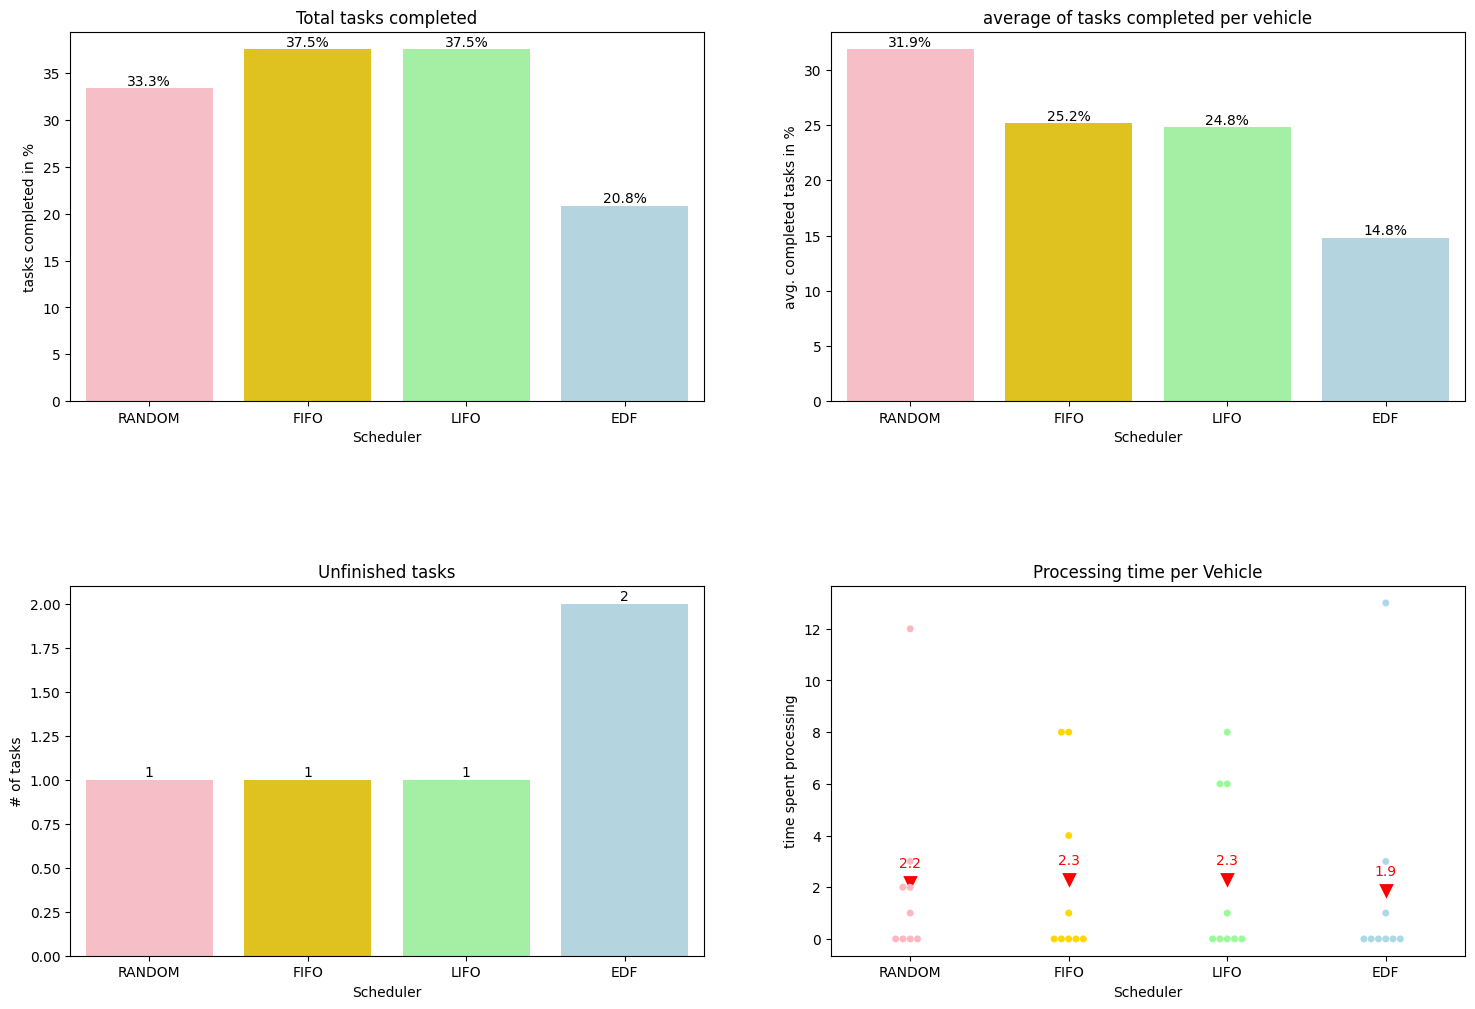

In [45]:
scheduling_type = ['RANDOM', 'FIFO', 'LIFO', 'EDF']

pastel_colors = ['#FFB6C1', '#FFD700', '#98FB98', '#ADD8E6']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.5)


# Plot 1
sns.barplot(x=scheduling_type, y=simulation_data['total tasks completed percentage'], ax=axes[0, 0], hue= scheduling_type, palette=pastel_colors)
axes[0, 0].set_title('Total tasks completed')
axes[0, 0].set_xlabel('Scheduler')
axes[0, 0].set_ylabel('tasks completed in %')

# Plot 2
sns.barplot(x=scheduling_type, y=simulation_data['avg. tasks completed per vehicle'], ax=axes[0, 1], hue= scheduling_type, palette=pastel_colors)
axes[0, 1].set_title('average of tasks completed per vehicle')
axes[0, 1].set_xlabel('Scheduler')
axes[0, 1].set_ylabel('avg. completed tasks in %')

# Plot 3
sns.barplot(x=scheduling_type, y=simulation_data['incomplete tasks'], ax=axes[1, 0], hue= scheduling_type, palette=pastel_colors)
axes[1, 0].set_title('Unfinished tasks')
axes[1, 0].set_xlabel('Scheduler')
axes[1, 0].set_ylabel('# of tasks')

# plot 4
sns.swarmplot(data=exploded_data, x='scheduling type', y='vehicle processing times', ax=axes[1, 1], hue= exploded_data['scheduling type'], palette=pastel_colors)
axes[1,1].set_title('Processing time per Vehicle')
axes[1,1].set_xlabel('Scheduler')
axes[1,1].set_ylabel('time spent processing')

#labeling the plots
for index, value in enumerate(simulation_data['total tasks completed percentage']):
    axes[0, 0].text(index, value, f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['avg. tasks completed per vehicle']):
    axes[0, 1].text(index, value,f"{round(value,1)}%", ha='center', va='bottom')

for index, value in enumerate(simulation_data['incomplete tasks']):
    axes[1, 0].text(index, value, str(value), ha='center', va='bottom')

sns.pointplot(data= simulation_data, x='scheduling type', y='mean vehicle processing times', color='red', markers='v', linestyle='none')

for i, row in simulation_data.iterrows():
    plt.text(i, row['mean vehicle processing times'] + 1, f'{row["mean vehicle processing times"]:.1f}', color='red', ha="center", va = "top")

plt.show()